# Plot GPS atomic clock data

This file downloads and plots data from the atomic clocks onboard the GPS satellites for a given day.

This dats is publicly available at: sideshow.jpl.nasa.gov/pub/jpligsac/

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from urllib import request
import gzip
import pandas as pd
from os import path

### GPS data is stored in files by week number (since 1970) and day (of the week)

Download it (if we don't have it already)

In [2]:
# week = 2299
# day_of_week = 0
week = 2310
day_of_week = 6

url = "https://sideshow.jpl.nasa.gov/pub/jpligsac/" + str(week) + "/"
filename = "jpl" + str(week) + str(day_of_week) + ".clk.gz"
dpath = "jpligsac/"

# Download the file (if we don't have it already)
if not path.isfile(dpath + filename):
    downloaded_file, info = request.urlretrieve(
        url + filename,
        dpath + filename,
    )
    assert downloaded_file == dpath + filename

### File format -- header

This file has a large 'header'.
It's usually ~96 lines long, but not always.
The header ends with the string: "END OF HEADER"
There is some useful info up there, but we don't need it.
We find the '"END OF HEADER"' string, and read the file from there:

In [3]:
def find_line_containing(file, the_string) -> int:
    for num, line in enumerate(file, 1):
        if the_string in line:
            return num


# Unip the file, and "read" as "text" to search for the string
unziped = gzip.open(dpath + filename, "rt")
header_line = find_line_containing(unziped, "END OF HEADER")
print("Found", header_line, "header lines")

Found 96 header lines


### Use pandas to read the data file

It is white-space delimetered (sometimes with multiple spaces).

The file is in a zipped (.gz) format - python knows how to deal with this.

It has 11 columns.

 * There are two "types" of clocks - satellite clocks (labelled "AS"), and ground recievers ("AR")
 * Each satelite clock has a name "G01" - "G32"
 * The main data is the time-stamp (YY MM DD HH MM SS), and the "bias"
 * The bias is the clock time difference (bias) compared to a common station clock
 * The "error" listed is actually just a fraction of the true error due to data processing

Here, we use pandas, because of its ability to deal with complicated data containing multiple types (in this case: strings, integers, and floats).

You could achieve the same results just with numpy, but this is more neat.

In [4]:
data = pd.read_csv(
    dpath + filename,
    skiprows=header_line,
    delimiter=" ",
    skipinitialspace=True,  # Interpret multiple spaces as 1 delimiter
    names=(  # Optional: give meaningful names to each column of data file:
        "Type",
        "Clock",
        "Year",
        "Month",
        "Day",
        "Hour",
        "Minute",
        "Second",
        "ncols",
        "Bias",
        "Error",
    ),
)

Get some useful info:
 * separate the "reciever" from "satellite" clocks
 * Extract the date
 * List unique satellite clock names

In [5]:
# Get the date from the file (it is in the filename, but here we get it from the file)
date_string = (
    str(data.iloc[0]["Year"])
    + "-"
    + str(data.iloc[0]["Month"])
    + "-"
    + str(data.iloc[0]["Day"])
)

print("Date of file:", date_string)
print()

# Generate the list of unique satellite clocks:
clock_list = np.sort(data[data.Type == "AS"]["Clock"].unique())
print("List of satellite clocks:")
print(clock_list)

Date of file: 2024-4-20

List of satellite clocks:
['G02' 'G03' 'G04' 'G05' 'G06' 'G07' 'G08' 'G09' 'G10' 'G11' 'G12' 'G13'
 'G14' 'G15' 'G16' 'G17' 'G18' 'G19' 'G20' 'G21' 'G22' 'G23' 'G24' 'G25'
 'G26' 'G27' 'G28' 'G29' 'G30' 'G31' 'G32']


### Convert time-stamps to plottable floats

The time stamps are given in an annoying "yy dd mm hh mm ss" format - 
We want to convert to a plottable float.


Define a function to convert "d/h/m/s" to "seconds since start of day".

We only plot 1 day, so we can ignore year/month.

We need to include the day, because midnight appears twice in the file!

In [6]:
def convert_time(row, day):
    return (
        row["Day"] * 24.0 * 60.0 * 60.0
        + row["Hour"] * 60.0 * 60.0
        + row["Minute"] * 60.0
        + row["Second"]
        - day * 24.0 * 60.0 * 60.0
    )


# Apply this conversion to each row, store in new column "Time"
keywords = {"day": data["Day"].iloc[0]}
data["Time"] = data.apply(convert_time, axis=1, **keywords)

sat_data = data[data.Type == "AS"]

## Plot the data

When plotting, we change the y-axis to nanoseconds, for improved legibility

### Remove large offset (calibration)

The clocks all show a reasonably significant offset.
This is essentially an "initial calibration offset", and can be removed without any issue.

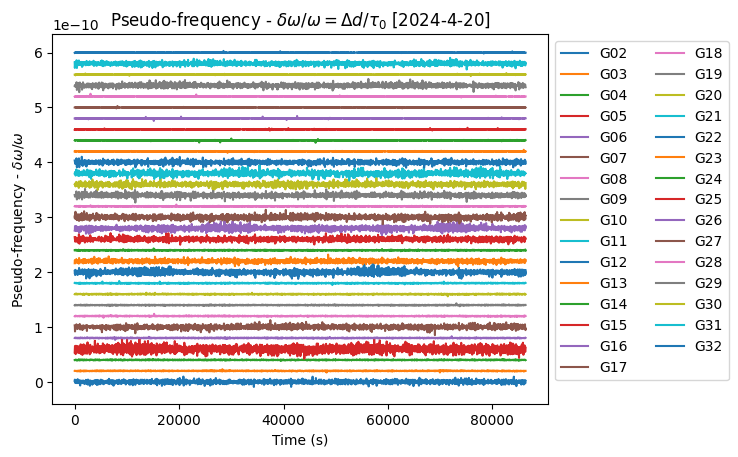

In [7]:
plt.title(
    f"Pseudo-frequency - $\\delta\\omega/\\omega = \\Delta d / \\tau_0$ [{date_string}]"
)
plt.xlabel("Time (s)")
plt.ylabel("Pseudo-frequency - $\\delta\\omega/\\omega$")

tau0 = 30.0

offset = 2e-11
for count, clock in enumerate(clock_list):
    t_data = sat_data[sat_data.Clock == clock]
    bias = t_data["Bias"]
    time = t_data["Time"]
    # constrct "pseudo-freqnency"
    dw = np.diff(bias) / tau0
    dw = dw - np.mean(dw) + offset * count
    plt.plot(time[:-1], dw, label=clock)
plt.legend(ncols=2, bbox_to_anchor=(1, 1))
plt.show()

## Just extract all the "pseudo frequencies"
The time bias between two clocks (averaged over averaging time $\tau$) is
$$
  \delta T(t) = \int_t^{t+\tau} \frac{\delta\omega(t)}{\omega_0} \, {\rm d}t = \frac{\delta\omega_{\rm av}(t)}{\omega_0} \tau
$$
where:
  * $\tau$ is the averaging time (30s in this case)
  * $\delta\omega$ is the deviation in freuquency from $\omega_0$, which is the clock frequency.
  * $\delta\omega_{\rm av}$ is the average of $\delta\omega$ over the averaging time.

$$
  \frac{\delta\omega_{\rm av}(t)}{\omega_0} = \frac{\delta T(t+\tau) - \delta T(t)}{\tau}
$$

In [8]:
tau0 = 30.0

# extract all frequencies into array
dws = [
    np.diff(sat_data[sat_data.Clock == clock]["Bias"]) / tau0 for clock in clock_list
]
t = sat_data[sat_data.Clock == clock_list[0]]["Time"][:-1].to_numpy()
# choose only full days!
assert len(t) == 2880

sigmas = [np.std(dw) for dw in dws]
clocks = clock_list

# Get indexes for clocks in order: best to worst
indexes = np.argsort(sigmas)


print(indexes)

[25 30  7  4  1 21  2 16 28 26  6 23 24 12 22  9  8 11  0 29 20  5 27 13
 17 18 15 14 10 19  3]


In [9]:
for i in indexes:
    print(f"{clocks[i]} sigma = {sigmas[i]:.2e}")

G27 sigma = 3.11e-13
G32 sigma = 3.17e-13
G09 sigma = 3.18e-13
G06 sigma = 3.21e-13
G03 sigma = 3.23e-13
G23 sigma = 3.27e-13
G04 sigma = 3.28e-13
G18 sigma = 3.34e-13
G30 sigma = 3.36e-13
G28 sigma = 3.36e-13
G08 sigma = 3.38e-13
G25 sigma = 3.41e-13
G26 sigma = 3.45e-13
G14 sigma = 3.55e-13
G24 sigma = 3.62e-13
G11 sigma = 3.72e-13
G10 sigma = 3.81e-13
G13 sigma = 2.15e-12
G02 sigma = 2.19e-12
G31 sigma = 2.34e-12
G22 sigma = 2.38e-12
G07 sigma = 2.51e-12
G29 sigma = 2.52e-12
G15 sigma = 2.53e-12
G19 sigma = 2.54e-12
G20 sigma = 2.67e-12
G17 sigma = 2.89e-12
G16 sigma = 3.00e-12
G12 sigma = 3.02e-12
G21 sigma = 3.18e-12
G05 sigma = 4.68e-12


## Weighted average of pseud-frequencies (OK?)
- Only include clocks with no missing data

In [10]:
dw_av = [dws[i] / (sigmas[i] ** 2) for i in range(len(dws))]
weights = [1.0 / (sigmas[i] ** 2) for i in range(len(dws))]

dw_av = 0.0 * dws[0]
w = 0.0
for i in range(len(dws)):
    # Only include clocks will no data gaps
    if dws[i].size != 2880:
        continue
    dw_av += (dws[i] - np.mean(dws[i])) / (sigmas[i] ** 2)
    w += 1.0 / (sigmas[i] ** 2)
dw_av /= w
print(w)
print(np.std(dw_av))
print(min(sigmas))

1.520133483690444e+26
2.2516253721515048e-13
3.1118232689213316e-13


G27 G06


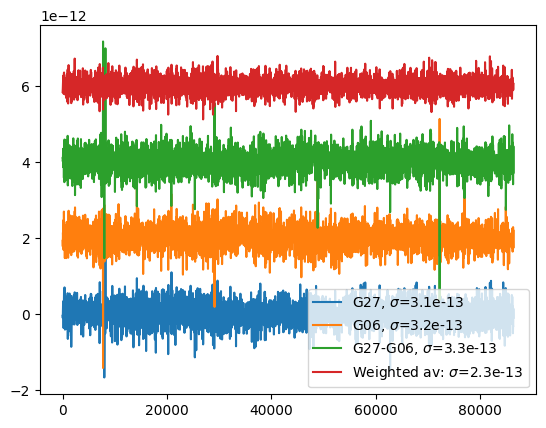

In [17]:
i1 = indexes[0]
i2 = 4
print(clocks[i1], clocks[i2])

dwL = (dws[i1] - np.mean(dws[i1])) - (dws[i2] - np.mean(dws[i2]))

plt.plot(
    t, dws[i1] - np.mean(dws[i1]), label=f"{clocks[i1]}, $\sigma$={sigmas[i1]:.1e}"
)
plt.plot(
    t,
    dws[i2] - np.mean(dws[i2]) + 2e-12,
    label=f"{clocks[i2]}, $\sigma$={sigmas[i2]:.1e}",
)
plt.plot(t, dwL + 4e-12, label=f"{clocks[i1]}-{clocks[i2]}, $\sigma$={np.std(dwL):.1e}")
plt.plot(t, dw_av + 6e-12, label=f"Weighted av: $\sigma$={np.std(dw_av):.1e}")
plt.legend()
plt.show()

## Histgorams: the data is white

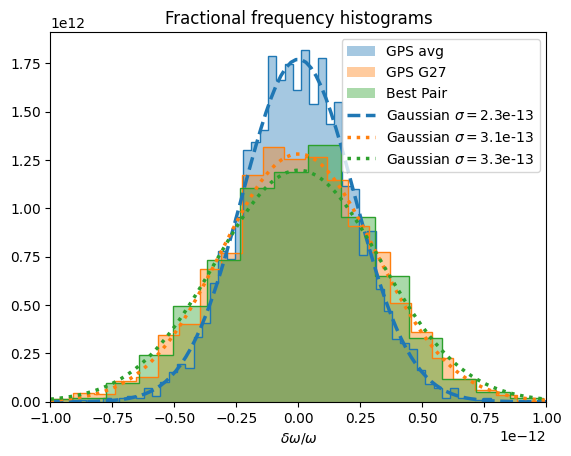

In [18]:
from scipy import stats

plt.hist(
    dw_av,
    bins=50,
    histtype="step",
    color="C0",
    density=True,
)
plt.hist(
    dw_av,
    bins=50,
    histtype="stepfilled",
    color="C0",
    alpha=0.4,
    density=True,
    label="GPS avg",
)

plt.hist(
    dws[indexes[0]] - np.mean(dws[indexes[0]]),
    bins=50,
    density=True,
    histtype="step",
    color="C1",
)
plt.hist(
    dws[indexes[0]] - np.mean(dws[indexes[0]]),
    bins=50,
    density=True,
    histtype="stepfilled",
    color="C1",
    alpha=0.4,
    label=f"GPS {clocks[indexes[0]]}",
)

plt.hist(
    dwL,
    bins=50,
    histtype="step",
    color="C2",
    density=True,
)
plt.hist(
    dwL,
    bins=50,
    histtype="stepfilled",
    color="C2",
    alpha=0.4,
    density=True,
    label="Best Pair",
)

x = np.linspace(-1e-12, 1e-12, 100)

plt.plot(
    x,
    stats.norm.pdf(x, np.mean(dw_av), np.std(dw_av)),
    label=f"Gaussian $\\sigma=${np.std(dw_av):.1e}",
    color="C0",
    linestyle="dashed",
    lw=2.5,
)
plt.plot(
    x,
    stats.norm.pdf(x, 0, np.std(dws[indexes[0]])),
    label=f"Gaussian $\\sigma=${np.std(dws[indexes[0]]):.1e}",
    color="C1",
    linestyle="dotted",
    lw=2.5,
)

plt.plot(
    x,
    stats.norm.pdf(x, 0, np.std(dwL)),
    label=f"Gaussian $\\sigma=${np.std(dwL):.1e}",
    color="C2",
    linestyle="dotted",
    lw=2.5,
)

plt.xlabel("$\\delta\\omega/\\omega$")
plt.xlim(-1e-12, 1e-12)
plt.title("Fractional frequency histograms")
plt.legend()
plt.show()

## Cavity data

In [19]:
cav = np.genfromtxt("./amplitudespectrum_data.txt")

## Amplitude spectrum

 * Inject fake oscillating signal, as a check

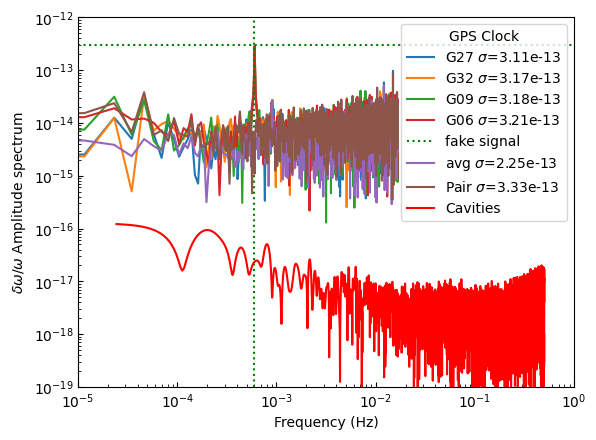

In [24]:
from scipy.fft import fft, fftshift, fftfreq


tau0 = 30.0

# number of clocks to include in plot (in order of goodness)
num_clocks = 4

freq = fftshift(fftfreq(t.size, d=tau0))

offset = 2e-11
for count, index in enumerate(indexes):

    clock = clock_list[index]
    dw = dws[index]
    sigma = sigmas[index]

    if len(dw) != 2880:
        continue
    if count >= num_clocks:
        continue

    # Inject fake signal: sanity check
    f_fake = 6e-4
    a_fake = 3.0e-13
    dw = dw + a_fake * np.sin(2 * np.pi * f_fake * t + 0.3)

    # Calculate amplitude spectrum:
    ft = fftshift(fft(dw))
    amp = 2.0 * np.abs(ft) / dw.size

    plt.plot(freq, amp, label=f"{clock} $\\sigma$={sigmas[index]:.2e}")


plt.axvline(f_fake, c="g", ls="dotted", label="fake signal")  #
plt.axhline(a_fake, c="g", ls="dotted")  #


# Weighted average:
ft = fftshift(fft(dw_av))
gps_avg = 2.0 * np.abs(ft) / dw.size

plt.plot(freq, gps_avg, label=f"avg $\\sigma$={np.std(dw_av):.2e}")

# "Best" pair
ft2 = fftshift(fft(dwL))
gps_L = 2.0 * np.abs(ft2) / dw.size
plt.plot(freq, gps_L, label=f"Pair $\\sigma$={np.std(dwL):.2e}")

# Previous data
plt.plot(cav[1:-1, 0], cav[1:-1, 1], label=f"Cavities", c="red")

# plt.title(f"Amplitude spectrum [{date_string}]")
plt.xlabel("Frequency (Hz)")
plt.ylabel("$\\delta\\omega/\\omega$ Amplitude spectrum")
plt.xlim(1e-5, 1)
plt.ylim(1e-19, 1e-12)
plt.xscale("log")
plt.yscale("log")
plt.legend(title="GPS Clock")
plt.tick_params(direction="in", which="both")
plt.show()

## Monte carlo: find 95% C.L.
- Since clock noise is so white, just random shuffle the actual data many times
- Another possibility is to just calculate the amplitude for many days
  - that would give us an average A, and a standard deviation

In [26]:
# For the weighted average:
temp_data = dw_av.copy()

num_mc = 250

tl = np.empty([num_mc, temp_data.size])
for count in range(num_mc):
    np.random.shuffle(temp_data)
    ft = fftshift(fft(temp_data))
    amp = 2.0 * np.abs(ft) / temp_data.size
    tl[count] = amp.copy()

ttl = np.mean(tl, axis=0)  # don't use the mean, but calculate anyway
ttl_s = np.std(tl, axis=0)

In [27]:
# For the "best" pair
temp_data = dwL.copy()

num_mc = 250

tl = np.empty([num_mc, temp_data.size])
for count in range(num_mc):
    np.random.shuffle(temp_data)
    ft = fftshift(fft(temp_data))
    amp = 2.0 * np.abs(ft) / temp_data.size
    tl[count] = amp.copy()

ttl2 = np.mean(tl, axis=0)
ttl2_s = np.std(tl, axis=0)

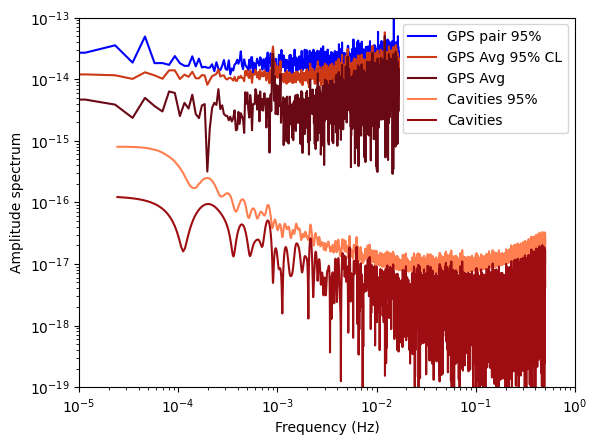

In [31]:
# Weighted average of clock data
gps_95cl = gps_avg + 2.0 * ttl_s
# Largest L (for best clocks)
gpsL_95cl = gps_L + 2.0 * ttl2_s


# plt.plot(freq, gps_L, label=f"GPS2 - A", c="blue", alpha=0.5)
plt.plot(freq, gpsL_95cl, label=f"GPS pair 95%", c="blue")

plt.plot(freq, gps_95cl, label=f"GPS Avg 95% CL", c="#cc3914")
# plt.plot(freq, ttl)
plt.plot(freq, gps_avg, label=f"GPS Avg", c="#690916")


plt.plot(cav[1:-1, 0], cav[1:-1, 2], label=f"Cavities 95%", c="coral")
plt.plot(cav[1:-1, 0], cav[1:-1, 1], label=f"Cavities", c="#9e0d11")


plt.ylabel("Amplitude spectrum")
plt.xlabel("Frequency (Hz)")
plt.xlim(1e-5, 1)
plt.ylim(1e-19, 1e-13)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

## Turn this into a limit

In [62]:
def f(m):
    return 2.4e14 * m


def m(f):
    return f / 2.4e14


f_stoch = 3
D = 25000
D2 = 55000


def dGPS(A):
    return f_stoch * A * 8.25e16 * (2220 / D) * 1.5


def dGPS2(A):
    return f_stoch * A * 8.25e16 * (2220 / D2) * 1.5


def dOld(A):
    return f_stoch * A * 8.25e16


# VERY rough, new cavity result from [just rescale form old formula]
def dCav(A):
    return f_stoch * A * 8.25e16 * (750.0 / 2220) * 1.5 * 2 * 1e3

In [63]:
# Previous limits
hqs = np.genfromtxt("./existing/HQuartzSapphire.txt")
rbq = np.genfromtxt("./existing/RbQuartz.txt")
hsi = np.genfromtxt("./existing/HSi.txt")
ybcs = np.genfromtxt("./existing/YbCs.txt")

# Correct for stochasticity
hqs[:, 1] = f_stoch * hqs[:, 1]

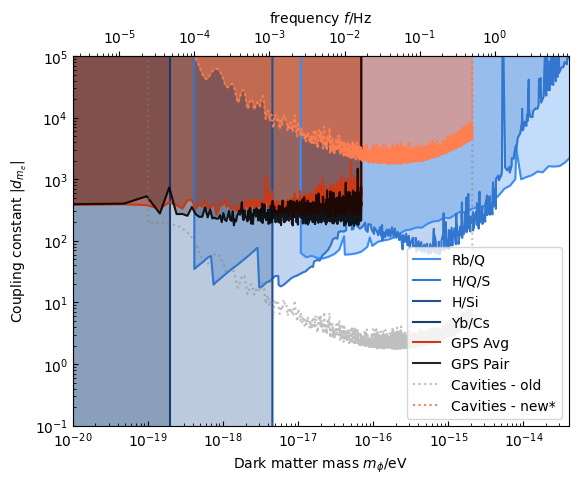

In [64]:
mm = np.append(m(freq), m(freq[-1]))
# dd = np.append(dGPS(gps_amp), 1e6)
dd = np.append(dGPS(gps_95cl), 1e6)

dd2 = np.append(dGPS2(gpsL_95cl), 1e6)


fig, ax = plt.subplots()

plt.plot(rbq[:, 0], rbq[:, 1], label="Rb/Q", color="#3d8df5")
plt.fill_between(rbq[:, 0], rbq[:, 1], 1e6, color="#3d8df5", alpha=0.3)

plt.plot(hqs[:, 0], hqs[:, 1], label="H/Q/S", color="#3276cf")
plt.fill_between(hqs[:, 0], hqs[:, 1], 1e6, color="#3276cf", alpha=0.3)

plt.plot(hsi[:, 0], hsi[:, 1], label="H/Si", color="#215291")
plt.fill_between(hsi[:, 0], hsi[:, 1], 1e6, color="#215291", alpha=0.3)

plt.plot(ybcs[:, 0], ybcs[:, 1], label="Yb/Cs", color="#183c6b")
plt.fill_between(ybcs[:, 0], ybcs[:, 1], 1e6, color="#183c6b", alpha=0.3)

plt.plot(mm, dd, label="GPS Avg", c="#cc3914")
plt.fill_between(mm, dd, 1e6, color="#cc3914", alpha=0.5)

plt.plot(mm, dd2, label="GPS Pair", c="k", alpha=0.85)
plt.fill_between(mm, dd2, 1e6, color="k", alpha=0.25)

plt.plot(
    m(cav[:, 0]),
    dOld(cav[:, 2]),
    label="Cavities - old",
    c="grey",
    ls="dotted",
    alpha=0.5,
)

plt.plot(
    m(cav[:, 0]),
    dCav(cav[:, 2]),
    label="Cavities - new*",
    c="coral",
    ls="dotted",
)
plt.fill_between(m(cav[:, 0]), dCav(cav[:, 2]), 1e6, color="coral", alpha=0.5)

plt.xlim(1e-20, 4e-14)
plt.ylim(1e-4, 1e4)
plt.ylim(1e-1, 1e5)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("")
plt.xlabel("Dark matter mass $m_\\phi/{\\rm eV}$")
plt.ylabel("Coupling constant $|d_{m_e}|$")
plt.legend(loc="lower right")
plt.tick_params(direction="in", which="both")


secax = ax.secondary_xaxis("top", functions=(f, m))
secax.set_xlabel("frequency $f/{\\rm Hz}$")

plt.show()